In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class Palanthir(object):
## Native attributes
    def __init__(self, input, target_feature:str=None, init_test_size:(float,None)=None):
        """Initiates a Palanthir-class on-top a Pandas Dataframe. The class-attributes describes the overall structure and composition of the data"""
        self.input_data = input
        ##When the Palanthir is born with a target variable:
        if isinstance(target_feature,str):
        #...AND is to be split into test-train subsets
            Y = [target_feature]
            X = [col for col in self.input_data.columns if col not in Y]
            if isinstance(init_test_size,float):
                self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.input_data[X],self.input_data[Y],test_size=0.2,random_state=42)
                self.output = self.train_X
        #...BUT IS NOT to be split into test-train subsets
            else:
                self.Y = self.input_data.copy(deep=True)[Y]
                self.X = self.input_data.copy(deep=True)[X]
                self.output = self.X
        ##When the Palanthir is NOT born with a target variable:
        else:
        # ...BUT IS to be split into test-train subsets
            if isinstance(init_test_size,float):
                self.train, self.test = train_test_split(self.input_data,test_size=0.2,random_state=42)
                self.output = self.train
        #...AND IS NOT to be split into test-train subsets.
            else:
                self.output = self.input_data.copy(deep=True)
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])
        self.current_version = 0
        self.transformation_history = [dict(version=0,transformation='input',result=self.input_data,pipeline=ColumnTransformer([]))]

## Self-update and audit commands

    def update_attributes(self):
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])

    def update_history(self, step=None, snapshot=None,text=None,transformer=None,cols=None):
        pipelineSteps = self.transformation_history[-1].get('pipeline').get_params().get('transformers') + [(text,transformer,cols)]
        updatedPipeline = ColumnTransformer(pipelineSteps)
        self.current_version += 1
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=step
                ,result=snapshot
                ,pipeline=updatedPipeline
            )
        )

    def restore(self, version=None):
        versionCheckpoint = (self.current_version - 1) if version == None else version
        self.current_version = versionCheckpoint
        self.output = self.transformation_history[versionCheckpoint].get('result')
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Restored to version {self.current_version}"
                ,result=self.transformation_history[self.current_version].get('result')
                ,pipeline=self.transformation_history[self.current_version].get('pipeline')
            )
        )

    def declare_target(self,target_feature:str):
        self.current_version += 1
        self.Y = self.input_data[[target_feature]]
        self.X = self.input_data[[col for col in self.input_data.columns if col not in self.Y]]
        self.output = self.X
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Split into X and Y"
                ,result=self.output
                ,pipeline=self.transformation_history[self.current_version-1].get('pipeline'))
        )
        return self.Y

## Summarization and description commands
    def summarize(self):
        """Prints the info, description and any missing value-counts for the class"""
        dataset = self.output
        return print(
            "Info: ", dataset.info(),
            "Description: ", dataset.describe(),
            "Missing values: ", dataset.isna().sum()
        )

## Data preprocessing commands
    def random_split(self, x=None, y=None, test_size=0.2, store=True):
        """Uses the SKLearn Train_Test_Split to divide the dataset into random training and test subset"""
        dataset_x = x if isinstance(x,pd.core.frame.DataFrame) else self.output.drop(columns=self.Y)
        dataset_y = y if isinstance(y,pd.core.frame.DataFrame) else self.output[self.Y]
        from sklearn.model_selection import train_test_split
        train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=test_size, random_state=42)
        if store:
            self.train_X = train_x
            self.train_Y = train_y
            self.test_X = test_x
            self.test_Y = test_y
        return train_x, train_y, test_x, test_y

    def stratified_split(self, cols, store=True):
        """Uses the SKLearn StratigiesShuffleSplit to divide the dataset into stratified training and test subset"""
        dataset = self.output
        from sklearn.model_selection import StratifiedShuffleSplit
        split = StratifiedShuffleSplit(n_split=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(dataset, dataset[cols]):
            strat_train_set = dataset.loc[train_index]
            strat_test_set = dataset.loc[test_index]
        if store:
            self.train_subset, self.test_subset = [strat_train_set], [strat_test_set]
        return strat_train_set, strat_test_set

    def execute_pipeline(self, dataset=None, pipeline_version=None):
        """Uses the SKLearn ColumnTransformer build via previous transformations and apply its transformations to the target dataset"""
        dataset = self.output if dataset==None else dataset
        versionCheckpoint = self.current_version if pipeline_version == None else pipeline_version
        pipeline = self.transformation_history[versionCheckpoint].get('pipeline')
        self.output = pipeline.transform(dataset)
        return self.output

## Transformation commands
    def PCA(self, n_components=0.80, include_features = [], exclude_features=[],store=True):
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.decomposition import PCA
        PCAtransformer = PCA(n_components=n_components).fit(dataset)
        pca_data = PCAtransformer.transform(dataset)
        output_df = pd.DataFrame(pca_data, columns=["PCA_" + str(col + 1) for col in range(pca_data.shape[1])],index=dataset.index)
        if store:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Performed Principal Component Analysis",snapshot=self.output,text='pca',transformer=PCAtransformer,cols=columns)
        explained_variance = PCA().fit(dataset).explained_variance_ratio_
        cumsum = np.cumsum(explained_variance)
        print(cumsum)
        plt.plot(["PCA" + str(num) for num in range(1, len(cumsum) + 1)], cumsum)
        plt.show()
        return output_df

    def fill_nulls(self, strategy="median", include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn SimpleImputer to fill out any missing values in the numerical features of the dataset"""
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy=strategy).fit(dataset)
        imputed_data = imputer.transform(dataset)
        output_df = pd.DataFrame(imputed_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step="Filled nulls",snapshot=self.output,text='impute',transformer=imputer,cols=columns)
        return output_df

    def encode_order(self, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn OrdinalEncoder to order any categorical features of the dataset"""
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.preprocessing import OrdinalEncoder
        encoder = OrdinalEncoder().fit(dataset)
        encoded_data = encoder.transform(dataset)
        output_df = pd.DataFrame(encoded_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step="Encoded order of categorial features",snapshot=self.output,text='ordinal',transformer=encoder,cols=columns)
        return output_df

    def make_dummies(self, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn OneHotEncoder to turn categorical features of the dataset into dummy-variables"""
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        remain_columns = [col for col in self.output.columns if col not in columns]
        dataset = self.output[columns]
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder().fit(dataset)
        new_column_names = encoder.get_feature_names_out(dataset.columns)
        dummy_data = encoder.transform(dataset).toarray()
        dummy_data_df = pd.DataFrame(dummy_data, columns=[name for name in new_column_names], index=dataset.index)
        output_df = pd.merge(self.output[remain_columns], dummy_data_df, left_index=True, right_index=True)
        if store == True:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Turned categorical features into dummy variables",snapshot=self.output,text='onehot',transformer=encoder,cols=columns)
        return output_df

    def scale(self, strategy:str, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn StandardScaler or MinMaxScaler to scale all numerical features of the dataset"""
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        if strategy=="Standard":
            scaler = StandardScaler().fit(dataset)
        elif strategy=="MinMax":
            scaler = MinMaxScaler().fit(dataset)
        else:
            print('Not a proper scaler')
        output_df = scaler.transform(dataset)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step=f"""Scaled feature-values using {'Standard-scaler' if strategy=='Standard' else 'MinMax-scaler'}""",snapshot=self.output,text='scaler',transformer=scaler,cols=columns)
        return output_df

    def cluster(self, max_k=10, store=True):
        """Uses the SKLearn KMeans to cluster the dataset"""
        dataset = self.output
        from sklearn.cluster import KMeans
        from matplotlib import pyplot
        from sklearn.metrics import silhouette_score
        kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(dataset) for k in range(1, max_k + 1)]
        silhouettes = [silhouette_score(dataset, model.labels_) for model in kmeans_per_k[1:]]
        best_k = silhouettes.index(max(silhouettes)) + 2
        plt.plot(range(2, max_k + 1), silhouettes)
        plt.xlabel("KMeans")
        plt.ylabel("Silhouette-score")
        plt.show()
        print("Best silhouette is obtained with k as: ", best_k)
        if store:
            self.output["Cluster"] = ["Cluster " + str(i) for i in KMeans(n_clusters=best_k, random_state=42).fit_predict(dataset)]
            self.update_attributes()
            self.update_history(step="Added Cluster-label as column to dataset",snapshot=self.output)
        return self.output

## Analysis commands
    def cross_validate(self, model, x, y, score_measure="neg_mean_squared_error", folds=10):
        """Uses the SKLearn Cross_Val_Score to cross-validate one/several models on the training subset"""
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(model, x, y, scoring=score_measure, cv=folds)
        return scores

    def full_analysis(self, model):
        """Conducts a full data-analysis pipeline on the dataset, including model training, evaluation and tuning"""
        dataset = self.output
        X_train, X_test, Y_train, Y_test = self.random_split(dataset)

        sqrt_scores = np.sqrt(-self.cross_validate(model, X_train, Y_train, score_measure="neg_mean_squared_error", folds=10))
        print(
            "RMSE-scores: ", sqrt_scores,
            "RMSE-mean: ", sqrt_scores.mean(),
            "RMSE-std: ", sqrt_scores.std()
        )

In [57]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)

In [66]:
pal = Palanthir(df)

In [67]:
#print(pal.train_X.shape,pal.train_Y.shape,pal.test_X.shape,pal.test_Y.shape)
#print(pal.train.shape,pal.test.shape)
#print(pal.X,pal.Y)

In [68]:
pal.scale(strategy="MinMax")

array([[0.21115538, 0.5674814 , 0.78431373, ..., 0.02055583, 0.53966842,
        0.90226638],
       [0.21215139, 0.565356  , 0.39215686, ..., 0.18697583, 0.53802706,
        0.70824656],
       [0.21015936, 0.5642933 , 1.        , ..., 0.02894261, 0.46602805,
        0.69505074],
       ...,
       [0.31175299, 0.73219979, 0.31372549, ..., 0.07104095, 0.08276438,
        0.15938285],
       [0.30179283, 0.73219979, 0.33333333, ..., 0.05722743, 0.09429525,
        0.14371281],
       [0.30976096, 0.72582359, 0.29411765, ..., 0.08699227, 0.13025338,
        0.15340349]])

In [69]:
pal.declare_target(target_feature='longitude')

,longitude
0,-122.23
1,-122.22
2,-122.24
3,-122.25
4,-122.25
...,...
20635,-121.09
20636,-121.21
20637,-121.22
20638,-121.32


In [70]:
pal.output

,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...
20635,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [71]:
pal.current_version

2

In [75]:
pal.transformation_history[1]

{'version': 1,
 'transformation': 'Scaled feature-values using MinMax-scaler',
 'result':        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 0       0.211155  0.567481            0.784314     0.022331        0.019863   
 1       0.212151  0.565356            0.392157     0.180503        0.171477   
 2       0.210159  0.564293            1.000000     0.037260        0.029330   
 3       0.209163  0.564293            1.000000     0.032352        0.036313   
 4       0.209163  0.564293            1.000000     0.041330        0.043296   
 ...          ...       ...                 ...          ...             ...   
 20635   0.324701  0.737513            0.470588     0.042296        0.057883   
 20636   0.312749  0.738576            0.333333     0.017676        0.023122   
 20637   0.311753  0.732200            0.313725     0.057277        0.075109   
 20638   0.301793  0.732200            0.333333     0.047256        0.063315   
 20639   0.309761  0.725824    

In [84]:
pal.random_split()

(       latitude  housing_median_age  total_rooms  total_bedrooms  population  \
 16490     38.00                27.0       1683.0           288.0       873.0   
 6090      34.10                15.0       6409.0          1363.0      3359.0   
 10973     33.76                26.0       2312.0           525.0      1273.0   
 17287     34.35                34.0       1664.0           292.0       705.0   
 12615     38.50                25.0       4719.0           745.0      1857.0   
 ...         ...                 ...          ...             ...         ...   
 5606      33.79                16.0       1867.0           571.0       951.0   
 16339     38.04                16.0       3295.0           565.0      2279.0   
 14965     32.74                18.0       3341.0           611.0      1952.0   
 11117     33.84                16.0       1545.0           354.0       730.0   
 8472      33.91                35.0        940.0           197.0       640.0   
 
        households  median

In [151]:
pal.train_Y

,longitude
14196,-117.03
8267,-118.16
17445,-120.48
14265,-117.11
2271,-119.80
...,...
11284,-117.96
11964,-117.43
5390,-118.38
860,-121.96


In [48]:
pal.transformation_history[0].get('pipeline')

ColumnTransformer(transformers=[])

In [45]:
pal.scale(strategy="MinMax")

C:\Users\JesperFrederiksen\AppData\Local\Temp\ipykernel_18552\1904548894.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.output.loc[:,columns] = output_df


array([[0.21115538, 0.5674814 , 0.78431373, ..., 0.02055583, 0.53966842,
        0.90226638],
       [0.21215139, 0.565356  , 0.39215686, ..., 0.18697583, 0.53802706,
        0.70824656],
       [0.21015936, 0.5642933 , 1.        , ..., 0.02894261, 0.46602805,
        0.69505074],
       ...,
       [0.31175299, 0.73219979, 0.31372549, ..., 0.07104095, 0.08276438,
        0.15938285],
       [0.30179283, 0.73219979, 0.33333333, ..., 0.05722743, 0.09429525,
        0.14371281],
       [0.30976096, 0.72582359, 0.29411765, ..., 0.08699227, 0.13025338,
        0.15340349]])

In [34]:
pal.current_version

1

In [51]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [53]:
pal.fill_nulls()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14196,0.729084,0.017021,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445
8267,0.616534,0.129787,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906
17445,0.385458,0.224468,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949
14265,0.721116,0.014894,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651
2271,0.453187,0.450000,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043
...,...,...,...,...,...,...,...,...,...
11284,0.636454,0.130851,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650
11964,0.689243,0.156383,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723
5390,0.594622,0.157447,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011
860,0.238048,0.535106,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608


In [54]:
pal.current_version

2

In [55]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

[0.37455444 0.66565168 0.9160475  0.95963728 0.98823227 0.99820514
 0.99904317 0.99976643 1.        ]


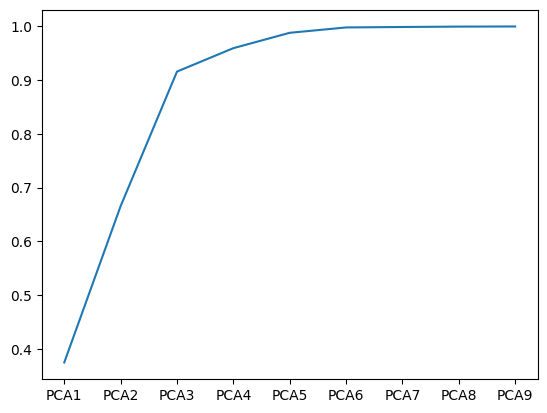

,PCA_1,PCA_2,PCA_3
14196,-0.346314,-0.161293,-0.255307
8267,-0.256607,0.478539,-0.186819
17445,-0.060488,-0.306309,0.343711
14265,-0.323302,-0.161691,-0.350513
2271,0.174545,-0.015436,-0.320787
...,...,...,...
11284,-0.253504,0.136474,-0.087312
11964,-0.213511,-0.167414,-0.243784
5390,-0.188160,0.072353,-0.160775
860,0.237957,0.032746,0.389031


In [56]:
pal.PCA()

In [57]:
pal.current_version

3

In [58]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('pca', PCA(n_components=0.8),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [59]:
pal.restore()

In [60]:
pal.current_version

2

In [61]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [64]:
pal.encode_order()

""
14196
8267
17445
14265
2271
...
11284
11964
5390
860


C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

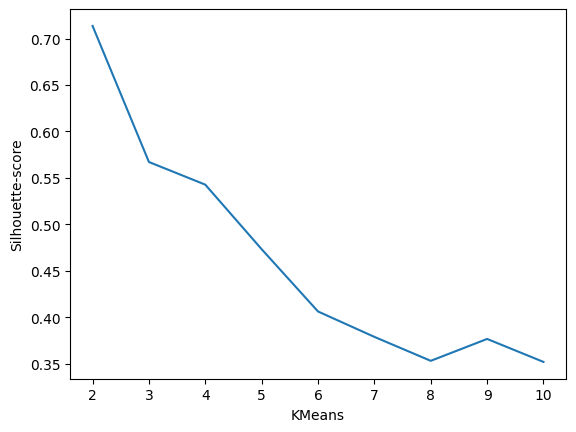

Best silhouette is obtained with k as:  2


C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,Cluster
14196,0.729084,0.017021,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445,4.0,Cluster 1
8267,0.616534,0.129787,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906,4.0,Cluster 1
17445,0.385458,0.224468,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949,4.0,Cluster 1
14265,0.721116,0.014894,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651,4.0,Cluster 1
2271,0.453187,0.450000,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043,1.0,Cluster 0
...,...,...,...,...,...,...,...,...,...,...,...
11284,0.636454,0.130851,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650,0.0,Cluster 0
11964,0.689243,0.156383,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723,1.0,Cluster 0
5390,0.594622,0.157447,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011,0.0,Cluster 0
860,0.238048,0.535106,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608,0.0,Cluster 0


In [65]:
pal.cluster()

In [66]:
pal.encode_order(include_features=['Cluster'])

,Cluster
14196,1.0
8267,1.0
17445,1.0
14265,1.0
2271,0.0
...,...
11284,0.0
11964,0.0
5390,0.0
860,0.0


In [67]:
pal.output

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,Cluster
14196,0.729084,0.017021,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445,4.0,1.0
8267,0.616534,0.129787,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906,4.0,1.0
17445,0.385458,0.224468,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949,4.0,1.0
14265,0.721116,0.014894,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651,4.0,1.0
2271,0.453187,0.450000,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11284,0.636454,0.130851,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650,0.0,0.0
11964,0.689243,0.156383,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723,1.0,0.0
5390,0.594622,0.157447,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011,0.0,0.0
860,0.238048,0.535106,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608,0.0,0.0


In [70]:
pal.current_version

6

In [71]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('ordinal', OrdinalEncoder(),
                                 ['ocean_proximity']),
                                ('ordinal', OrdinalEncoder(), []),
                                (None, None, None),
                                ('ordinal', OrdinalEncoder(), ['Cluster'])])

In [140]:
pal.restore(version=3)

In [141]:
pal.current_version

3

In [142]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=['scaler', MinMaxScaler(),
                                ['longitude', 'latitude'], 'impute',
                                SimpleImputer(strategy='median'),
                                ['longitude', 'latitude'], 'pca',
                                PCA(n_components=0.8), ['median_income']])

In [ ]:
X = df.drop(columns=['ocean_proximity'])
Y = df['ocean_proximity']

In [28]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=0.20, random_state=42)

In [33]:
len(test_X)

4128